## HW3: Decision Tree and Random Forest
In hw3, you need to implement decision tree and random forest by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

In [1]:
!pip install sklearn

You should consider upgrading via the 'c:\users\stan2\anaconda3\python.exe -m pip install --upgrade pip' command.


## Load data

In [70]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from math import *
import matplotlib.pyplot as plt

In [2]:
data = load_breast_cancer()
feature_names = data['feature_names']
print(feature_names)


1


In [3]:
# I first thought the data wouldbe in the same form than the one in load_breast_cancer so I modified this afterwards to fit it in the algorithm
x_train = pd.read_csv("x_train.csv").values
y_train = pd.read_csv("y_train.csv").values.T[0]
x_test = pd.read_csv("x_test.csv").values
y_test = pd.read_csv("y_test.csv").values.T[0]

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 7 of hw3 slides](https://docs.google.com/presentation/d/1ish3jEr_6be0FK4kgOZa12nYAyJFh0P2LCNsNPOCiXo/edit#slide=id.g7703d1636d_0_21)

In [130]:

def gini(sequence):
    N = len(sequence)
    if N == 0: return(0)
    # we use a dictionnary to count
    compteur = {}
    result = 1
    for c in sequence:
        if c in compteur : compteur[c] += 1
        else: compteur[c] = 1
    for c in compteur:
        result -= (compteur[c]/N)**2
    return result

def entropy(sequence):
    N = len(sequence)
    if N == 0: return(0)
    compteur = {}
    result = 0
    for c in sequence:
        if c in compteur : compteur[c] += 1
        else: compteur[c] = 1
    for c in compteur:
        result -= (compteur[c]/N)*log(compteur[c]/N, 2)
    return result

In [131]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])
print(data)

[1 2 1 1 1 1 2 2 1 1 2]


In [132]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [133]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006402


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **Criterion**: The function to measure the quality of a split. Your model should support “gini” for the Gini impurity and “entropy” for the information gain. 
2. **Max_depth**: The maximum depth of the tree. If Max_depth=None, then nodes are expanded until all leaves are pure. Max_depth=1 equals to split data once


In [153]:
class DecisionTree():
    criterion = None
    max_depth = None

    # some useful attributes to save
    train_data = None
    target = None
    tree = None
    feature_importance = None

    def __init__(self, criterion='gini', max_depth=None):
        self.max_depth = max_depth
        self.criterion = criterion
        return
    
    # splitting of the data and evaluation of the split
    def splitting_test(self, sequence, feature, threshold):
        left, right = [], []
        # I decided to work with the position of the different data samples
        for i in sequence:
            if (self.train_data[i][feature] <= threshold):
                left += [i]
            else:
                right += [i]
        l_score = eval(self.criterion)(np.array([self.target[i] for i in left]))
        r_score = eval(self.criterion)(np.array([self.target[i] for i in right]))
        score = (len(left)*l_score + len(right)*r_score)/len(sequence)
        return(left, right, score)
    
    def find_split(self, sequence):
        best_score = 1
        for feature in range(len(self.train_data[0])):
            for i in range(len(sequence)-1):
                # I chose the average value between two consecutive samples as threshold
                threshold = (self.train_data[i][feature] + self.train_data[i+1][feature])/2
                left, right, score = self.splitting_test(sequence, feature, threshold)
                if score < best_score:
                    best_feature = feature
                    best_threshold = threshold
                    best_left, best_right = left, right
                    best_score = score
        # here I decided to return the score as well so I can use it as an ending condition later
        return({'feature':best_feature, 'threshold':best_threshold, 'left':best_left, 'right':best_right}, best_score)

    def predict_class(self, sequence):
        counter = {}
        for i in sequence:
            c = self.target[i]
            if c in counter: counter[c] += 1
            else: counter[c] = 1
        return(max(counter, key=counter.get))
    
    # recursive function to split the node, we also count the feature importance in this function
    def split_node(self, node, depth, score):
        left = node['left']
        right = node['right']
        self.feature_importance[node['feature']] += score*len(left + right)
        # checking the ending conditions
        if len(left) == 0 or len(right) == 0:
            node['left'] = node['right'] = self.predict_class(left + right)
            return
        if (self.max_depth != None and depth >= self.max_depth) or score == 0:
            node['left'] = self.predict_class(left)
            node['right'] = self.predict_class(right)
            return
        # splitting left child (I had to separate the case where the child was length one because of my choice of threshold)
        if len(left) == 1:
            node['left'] = self.predict_class(left)
        else:
            node['left'], l_score = self.find_split(left)
            self.feature_importance[node['feature']] -= l_score*len(left)
            self.split_node(node['left'], depth+1, l_score)
        # splitting right child
        if len(right) == 1:
            node['right'] = self.predict_class(right)
            return
        else:
            node['right'], r_score = self.find_split(right)
            self.feature_importance[node['feature']] -= r_score*len(right)
            self.split_node(node['right'], depth+1, r_score)
    
    # we use the recursive function to build the tree
    def build_tree(self, data, target):
        # we save the data and target for training
        self.train_data = data
        self.target = target
        # we initialise the feature importance counter
        self.feature_importance = np.zeros((len(self.train_data[0])))
        # the first split will be made on the sequence corresponding to the whole dataset
        root, score = self.find_split(range(len(self.train_data)))
        self.split_node(root, 1, score)
        self.tree = root
    
    # recursive function to predict a sample's class using the tree
    def predict_from_node(self, node, sample):
        if sample[node['feature']] <= node['threshold']:
            next_node = node['left']
        else:
            next_node = node['right']
        if isinstance(next_node, dict):
            return(self.predict_from_node(next_node, sample))
        else:
            return(next_node)

    # final function to predict a class
    def predict(self, data_point):
        return(self.predict_from_node(self.tree, data_point))


In [154]:
# Here we define a function measuring the accuracy of the trees
def accuracy_score(decision_tree, train_data, train_target, test_data, test_target):
    correct = 0
    decision_tree.build_tree(train_data, train_target)
    for i in range(len(test_data)):
        prediction = decision_tree.predict(test_data[i])
        if test_target[i] == prediction:
            correct += 1
    return correct / len(test_data)

### Question 2.1
Using Criterion=‘gini’, showing the accuracy score of test data by Max_depth=3 and Max_depth=10, respectively.


In [155]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
print('score for Max_depth=3: ' + str(accuracy_score(clf_depth3, x_train, y_train, x_test, y_test)))
print('score for Max_depth=10: ' + str(accuracy_score(clf_depth10, x_train, y_train, x_test, y_test)))

score for Max_depth=3: 0.9440559440559441
score for Max_depth=10: 0.9370629370629371


### Question 2.2
Using Max_depth=3, showing the accuracy score of test data by Criterion=‘gini’ and Criterion=’entropy’, respectively.


In [138]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
print('score for gini criterion: ' + str(accuracy_score(clf_gini, x_train, y_train, x_test, y_test, feature_names)))
print('score for entropy criterion: ' + str(accuracy_score(clf_entropy, x_train, y_train, x_test, y_test, feature_names)))

score for gini criterion: 0.9440559440559441
score for entropy criterion: 0.958041958041958


- Note: All of your accuracy scores should over 0.9
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the feature counts for building tree without normalize the importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

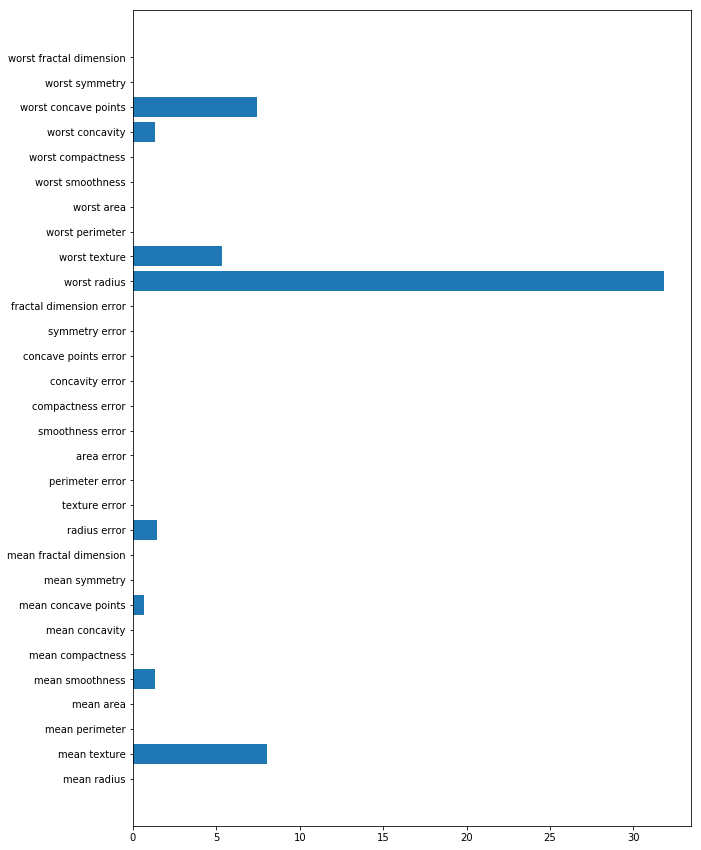

In [156]:
plt.rcParams["figure.figsize"] = (10,15)
def plot_feature_importance(tree):
    feature_importance = tree.feature_importance
    ypos = np.arange(1, len(feature_importance)+1)
    plt.barh(ypos, feature_importance)
    plt.yticks(ypos, feature_names)

plot_feature_importance(clf_depth10)

## Question 4
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement two arguments for the Random Forest.

1. **N_estimators**: The number of trees in the forest. 
2. **Max_features**: The number of random select features to consider when looking for the best split
3. **Bootstrap**: Whether bootstrap samples are used when building tree


In [171]:
class RandomForest():
    # arguments
    n_estimators = None
    max_features = None
    boostrap = None
    criterion = None
    max_depth = None
    # useful attributes
    train_data = None
    train_target = None
    forest = []
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        return None
    
    # recursive sampling function
    def sample(self, n, size, sequence):
        if n == 0: return([])
        else: 
            np.random.shuffle(sequence)
            if self.boostrap: return([sequence[:size]] + self.sample(n-1, size, sequence))
            else: return([sequence[:size]] + self.sample(n-1, size, sequence[size:]))
    
    # function returning a list of training data samples position
    def get_samples(self):
        # I did not know what to choose for sample size so I went with this
        size = int((1+self.boostrap)*len(self.train_data)/self.n_estimators)
        return(self.sample(self.n_estimators, size, np.arange(len(self.train_data))))
    
    # we build each tree with the samples
    def build_forest(self, train_data, train_target):
        self.train_data = train_data
        self.train_target = train_target
        samples = self.get_samples()
        for s in samples:
            tree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth)
            # we get data and target samples from their position, for now I haven't implemented the subsets of features
            data_sample = np.array([train_data[i] for i in s])
            data_target = np.array([train_target[i] for i in s])
            tree.build_tree(train_data, train_target)
            self.forest += [tree]
        return
    
    def majority_vote(self, results):
        counter = {}
        for c in results:
            if c in counter: counter[c] += 1
            else: counter[c] = 1
        return(max(counter, key=counter.get))

    def predict(self, data_point):
        results = []
        for tree in self.forest:
            results += [tree.predict(data_point)]
        return(self.majority_vote(results))



t = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
t.build_forest(x_train, y_train)
    


### Question 4.1
Using Criterion=‘gini’, Max_depth=None, Max_features=sqrt(n_features), showing the accuracy score of test data by n_estimators=10 and n_estimators=100, respectively.


In [12]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))

### Question 4.2
Using Criterion=‘gini’, Max_depth=None, N_estimators=10, showing the accuracy score of test data by Max_features=sqrt(n_features) and Max_features=n_features, respectively.


In [13]:
clf_all_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_random_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 